In [1]:
import pandas as pd
from scipy.optimize import minimize, curve_fit
from utils import *


path = "./revlog.csv"

df = create_time_series(pd.read_csv(path))

0.7472840356344073 0.4217394202405182 0.40244846692996883
0.6922748314090008
0.7114817802421577
0.7147933061775754


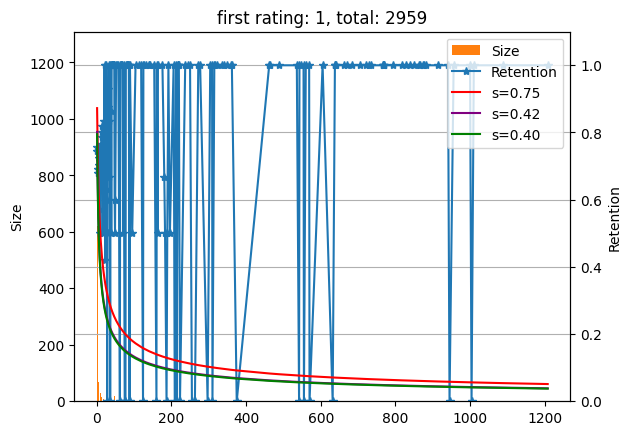

34.14982503135213 6.8662452683093775 4.444134855246156
0.33523190759962285
0.3834844371890687
0.41616336727046305


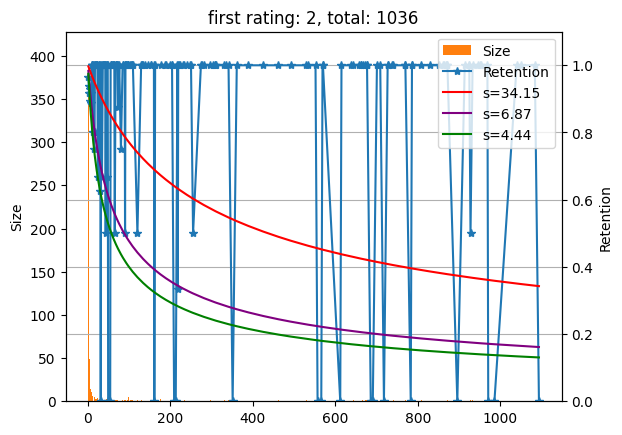

26.688067117680742 7.368911317578087 8.671527418265246
0.15040925980864606
0.16798551430425918
0.16334107974853632


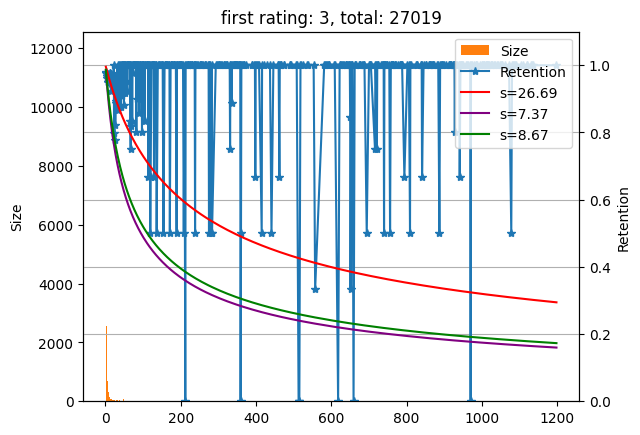

365.0 277.09113991840997 364.9999999999035
0.22634613652414773
0.2345521325610204
0.2263461365241538


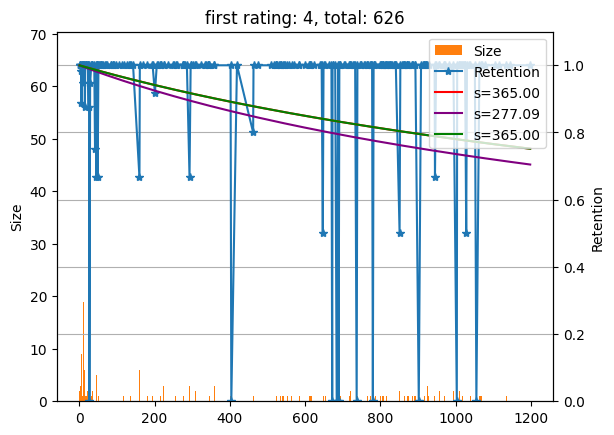

In [5]:
from sklearn.metrics import log_loss
import statsmodels.api as sm

def fit_stability(delta_t, retention, size):
    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred))
            * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.01, 365)])
    return res.x[0]



def linear_regression(delta_t, retention, size):
    DECAY = -0.5
    FACTOR = 0.9 ** (1 / DECAY) - 1
    y = (np.power(retention, 1/DECAY) - 1).clip(0, 5)
    x = delta_t
    total_cnt = sum(size)
    weight = np.power(size / total_cnt, 3)
    sum_wxx = sum(x * x * weight)
    sum_wxy = sum(x * y * weight)
    a = sum_wxy / sum_wxx
    return FACTOR / a

for r_history in ("1", "2", "3", "4"):
    group = df[df["r_history"] == r_history]
    fig = plt.figure()
    if group.empty:
        continue
    sub_group = (
        group.groupby("delta_t").agg({"y": ["mean", "count"]}).reset_index()
    )
    delta_t = sub_group["delta_t"]
    retention = sub_group[("y", "mean")]
    size = sub_group[("y", "count")]
    stability_fit = fit_stability(delta_t, retention, size)
    stability_regression = linear_regression(delta_t, retention, size)
    stability_curve_fit = curve_fit(
                        power_forgetting_curve,
                        delta_t,
                        retention,
                        sigma=1 / size,
                        p0=[1],
                        bounds=([0.01], [365]),
                    )[0][0]
    print(stability_fit, stability_regression, stability_curve_fit)

    total_cnt = sum(sub_group[("y", "count")])
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.bar(delta_t, size, color="#ff7f0e", ec="k", linewidth=0, label="Size")
    ax1.set_ylim(0, max(size) * 1.1)
    ax1.set_ylabel("Size")
    ax2 = ax1.twinx()
    ax2.plot(delta_t, retention, color="#1f77b4", marker="*", label="Retention")
    ax2.plot(
        delta_t,
        power_forgetting_curve(delta_t, stability_fit),
        color="red",
        label=f"s={stability_fit:.2f}",
    )
    print(log_loss(group["y"], power_forgetting_curve(group["delta_t"], stability_fit)))
    ax2.plot(
        delta_t,
        power_forgetting_curve(delta_t, stability_regression),
        color="purple",
        label=f"s={stability_regression:.2f}",
    )
    print(log_loss(group["y"], power_forgetting_curve(group["delta_t"], stability_regression)))
    ax2.plot(
        delta_t,
        power_forgetting_curve(delta_t, stability_curve_fit),
        color="green",
        label=f"s={stability_curve_fit:.2f}",
    )
    print(log_loss(group["y"], power_forgetting_curve(group["delta_t"], stability_curve_fit)))
    ax2.set_ylim(0, 1.1)
    ax2.set_title(f"first rating: {r_history}, total: {total_cnt}")
    ax2.set_xlabel("delta_t")
    ax2.set_ylabel("Retention")
    ax2.grid(True)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    ax2.legend(handles, labels, loc="upper right")
    plt.show()